In [2]:

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import keras
from keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras import metrics

from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import f1_score, roc_auc_score

import sklearn.metrics 
import seaborn as sns



In [3]:
batch_size = 32
img_height = 224
img_width = 224
base_learning_rate = 0.001

data_dir= "Pollen_RawData/"
lice_dir = "Lice_dataset/"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,  # no need to shuffle validation set
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

test_ds = tf.keras.utils.image_dataset_from_directory(
  lice_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 206 files for validation.
Found 1239 files belonging to 5 classes.


In [24]:
class_names = train_ds.class_names
print(class_names)

['Eringonum rosense', 'Eriogonum umbellatum', 'Erysimum capitatum', 'Penstemon eatonii', 'Purshia tridentata']


In [25]:
class_names = val_ds.class_names
print(class_names)

['Eringonum rosense', 'Eriogonum umbellatum', 'Erysimum capitatum', 'Penstemon eatonii', 'Purshia tridentata']


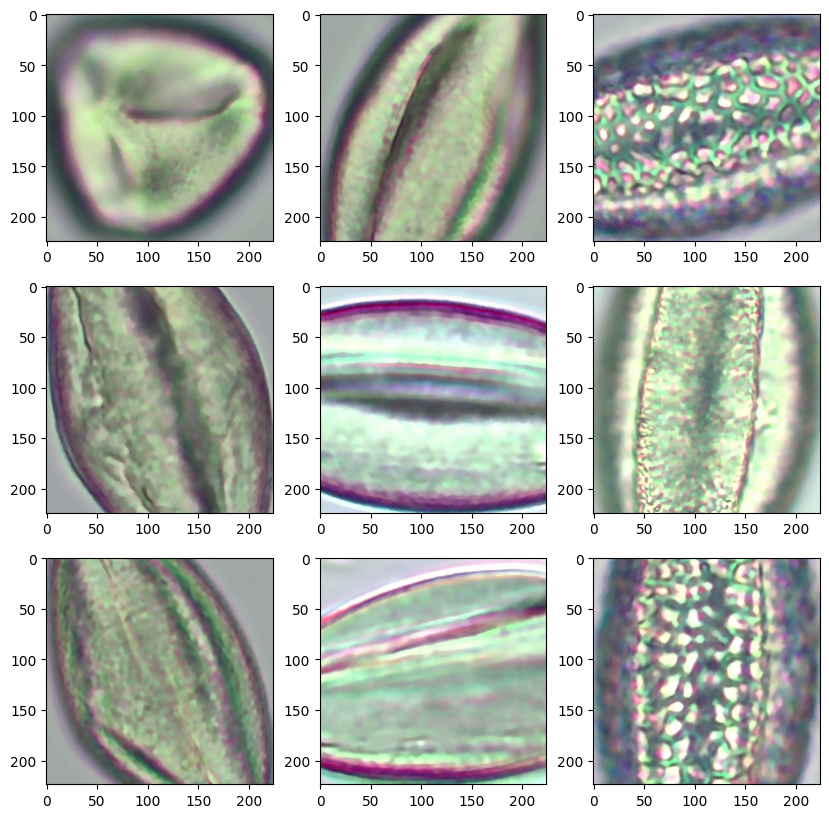

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.axis("on")

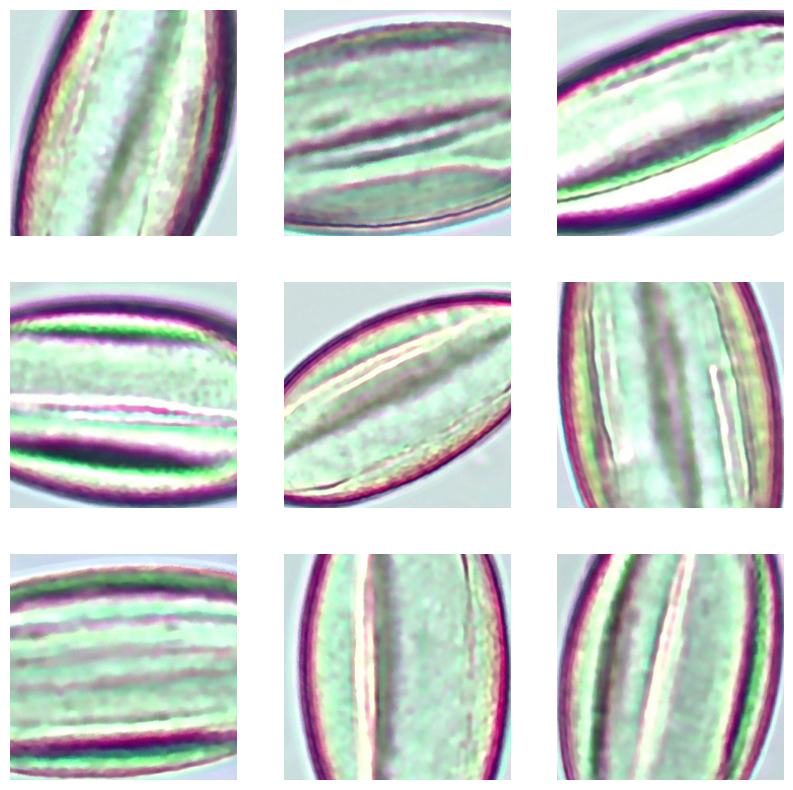

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.axis("off")

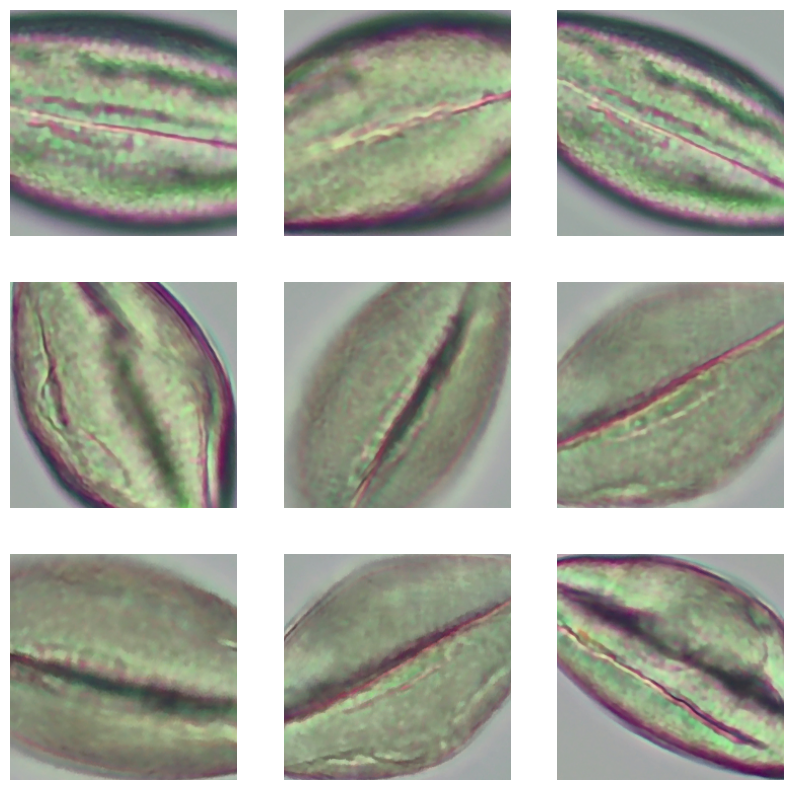

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(32):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./224)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.21406652 1.1383929


# DATA AUGMENTATION 

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),  # flip horizontally and vertically
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # translate horizontally and vertically
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.GaussianNoise(1),
  tf.keras.layers.RandomContrast(0.75)
])

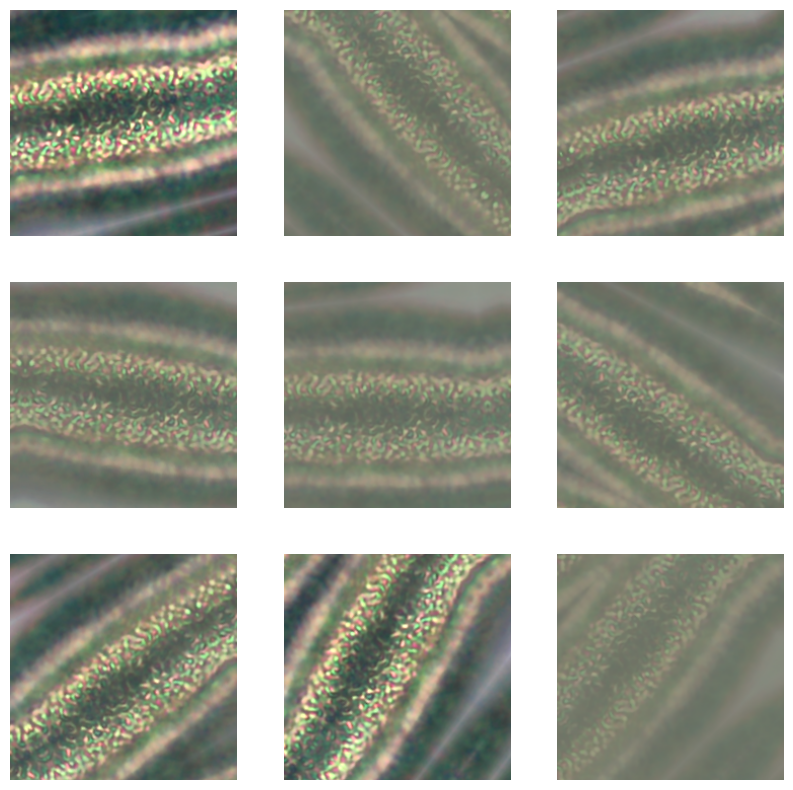

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(5):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

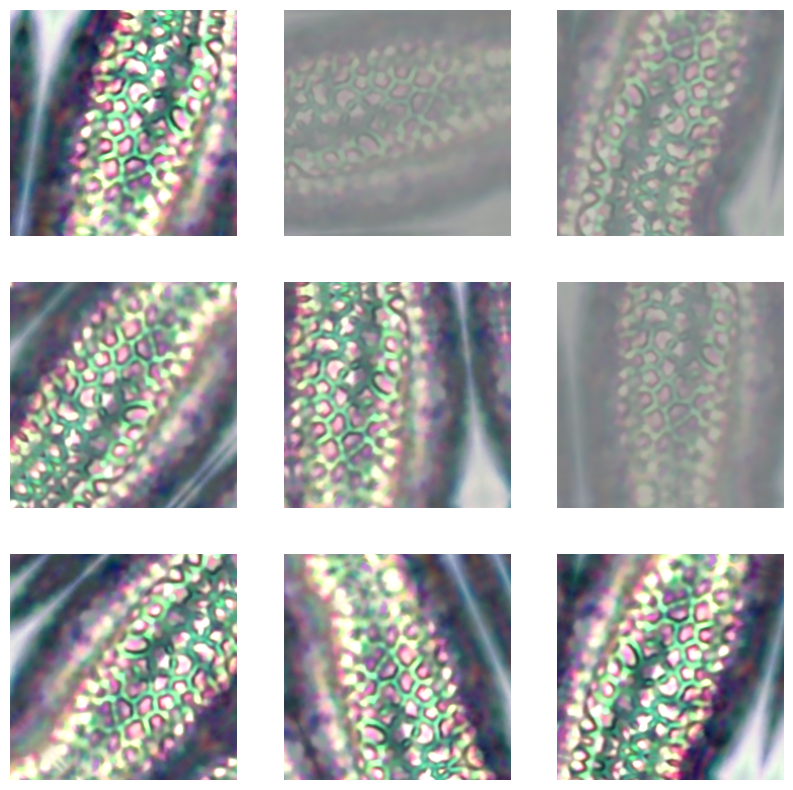

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## MobileNetV2 First Try

In [14]:
# Create the base model from the pre-trained model MobileNet V2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SIZE= (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=5)

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(5, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)


inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [15]:


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.95,
    decay_steps=100  # adjust this to control how often the learning rate decays
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1'),
                       tf.keras.metrics.AUC(name='auc')])


In [16]:
initial_epochs = 50

results = model.evaluate(val_ds)
loss0, accuracy0 = results[:2]  # extract the first two values

7/7 [==============================] - 2s 97ms/step - loss: 2.7485 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1: 0.0000e+00 - auc: 0.2143


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.75
initial accuracy: 0.00


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 [==============================] - 7s 157ms/step - loss: 1.6288 - accuracy: 0.2971 - precision: 0.3097 - recall: 0.1739 - f1: 0.2172 - auc: 0.5591 - val_loss: 1.4616 - val_accuracy: 0.2524 - val_precision: 0.5122 - val_recall: 0.2039 - val_f1: 0.1083 - val_auc: 0.5831
Epoch 2/50
26/26 [==============================] - 4s 151ms/step - loss: 1.2610 - accuracy: 0.5133 - precision: 0.5660 - recall: 0.4457 - f1: 0.3970 - auc: 0.6995 - val_loss: 1.4861 - val_accuracy: 0.2864 - val_precision: 0.3742 - val_recall: 0.2816 - val_f1: 0.1026 - val_auc: 0.5761
Epoch 3/50
26/26 [==============================] - 4s 151ms/step - loss: 0.9817 - accuracy: 0.6039 - precision: 0.6756 - recall: 0.5809 - f1: 0.4712 - auc: 0.7630 - val_loss: 1.3606 - val_accuracy: 0.2816 - val_precision: 0.4874 - val_recall: 0.2816 - val_f1: 0.1184 - val_auc: 0.5988
Epoch 4/50
26/26 [==============================] - 4s 149ms/step - loss: 0.8732 - accuracy: 0.6292 - precision: 0.7246 - recall: 0.6039 - f1:

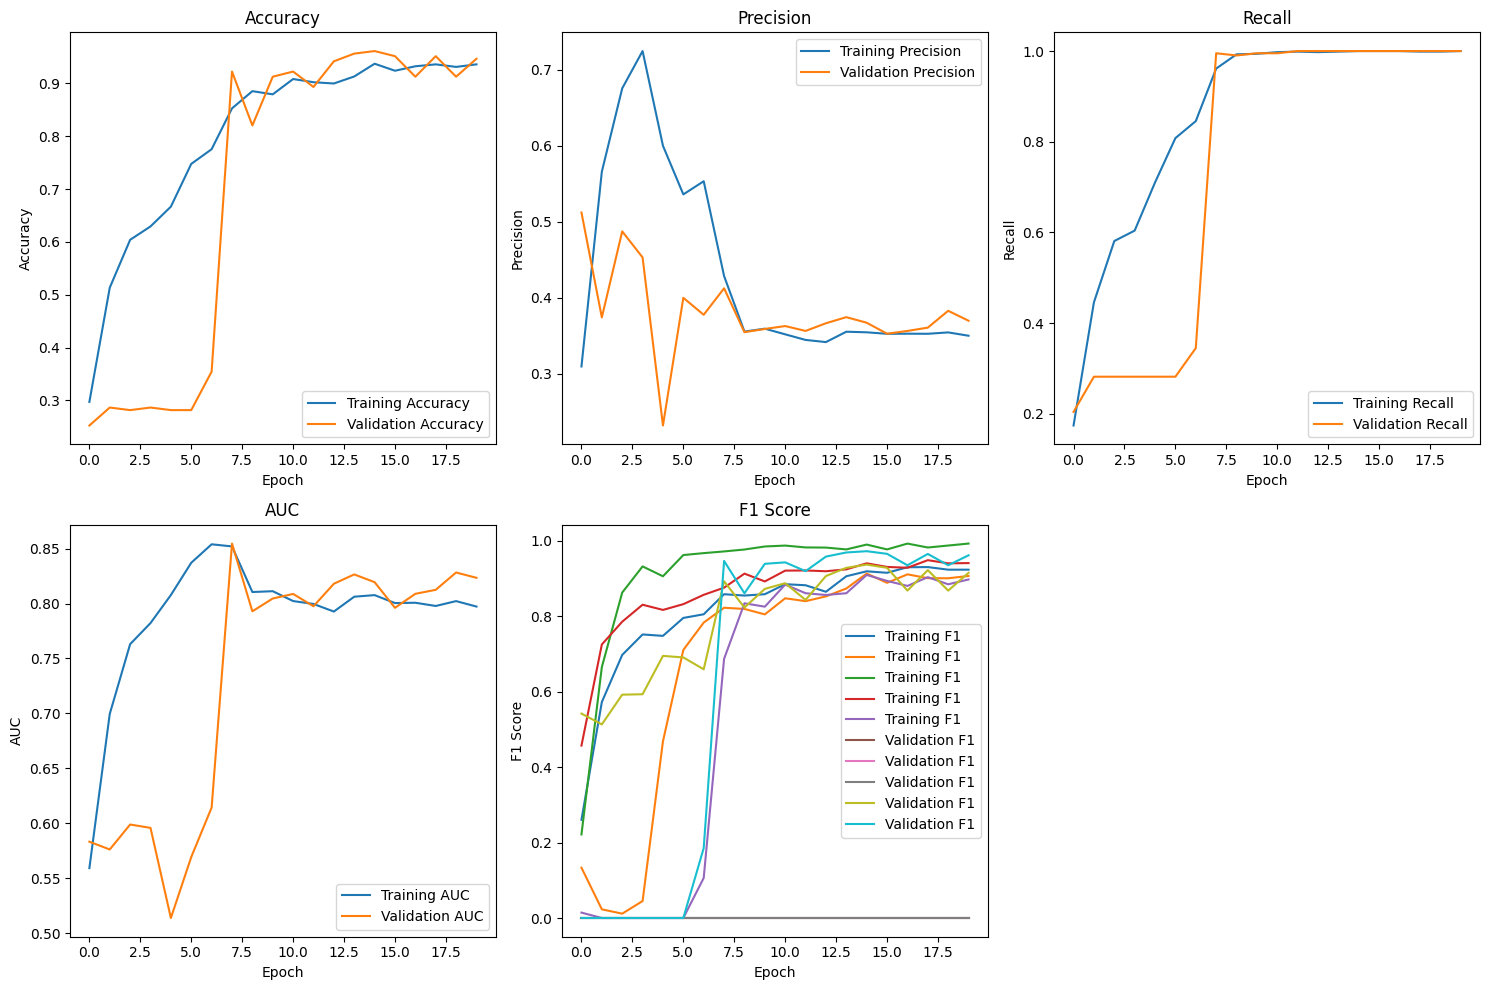

In [19]:
import matplotlib.pyplot as plt

# Assuming you have the following metrics:


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

# Create a figure and axis object
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Plot accuracy
ax[0, 0].plot(accuracy, label='Training Accuracy')
ax[0, 0].plot(val_accuracy, label='Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

# Plot precision
ax[0, 1].plot(precision, label='Training Precision')
ax[0, 1].plot(val_precision, label='Validation Precision')
ax[0, 1].set_title('Precision')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].legend()

# Plot recall
ax[0, 2].plot(recall, label='Training Recall')
ax[0, 2].plot(val_recall, label='Validation Recall')
ax[0, 2].set_title('Recall')
ax[0, 2].set_xlabel('Epoch')
ax[0, 2].set_ylabel('Recall')
ax[0, 2].legend()

# Plot AUC
ax[1, 0].plot(auc, label='Training AUC')
ax[1, 0].plot(val_auc, label='Validation AUC')
ax[1, 0].set_title('AUC')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].legend()

# Plot F1
ax[1, 1].plot(f1, label='Training F1')
ax[1, 1].plot(val_f1, label='Validation F1')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('F1 Score')
ax[1, 1].legend()

# Remove the last subplot (since we only have 5 metrics)
fig.delaxes(ax[1, 2])

# Show the plot
plt.tight_layout()
plt.show()

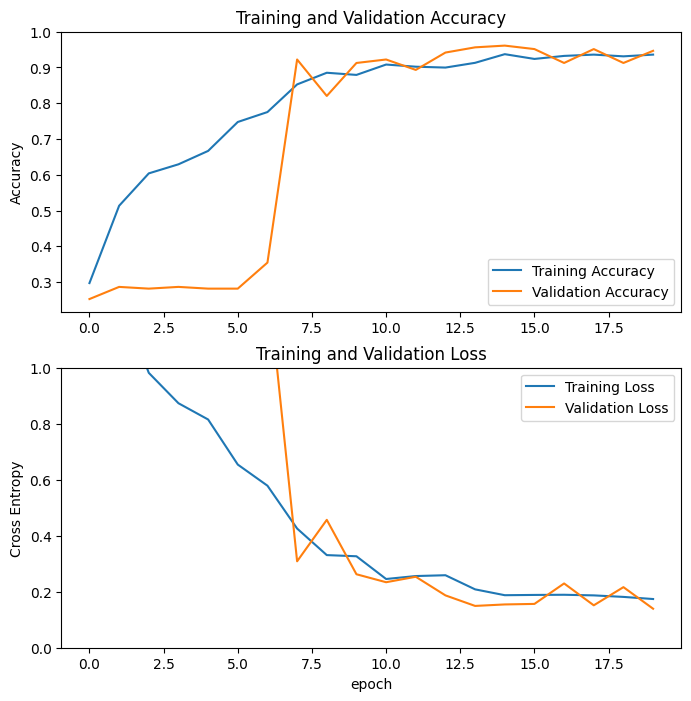

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## CONF MATRIX FOR TRAINING

1/1 [==============================] - 0s 91ms/step


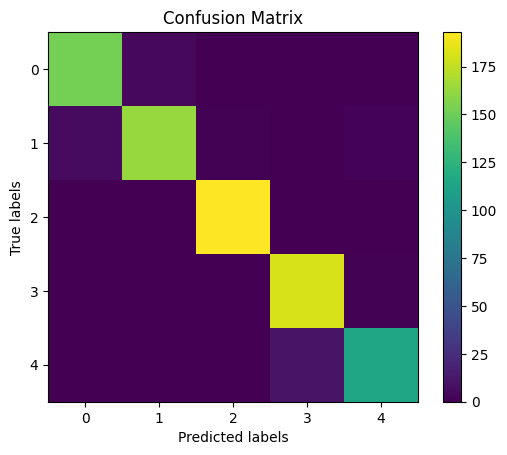

In [23]:
y_true_list = []
y_pred_list = []

for x, y in train_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [24]:
print(cm)

[[153   4   0   0   0]
 [  6 163   1   0   2]
 [  0   0 193   0   0]
 [  0   0   0 181   1]
 [  0   0   0  10 114]]


## CONF MATRIX FOR VALIDATION

1/1 [==============================] - 0s 64ms/step


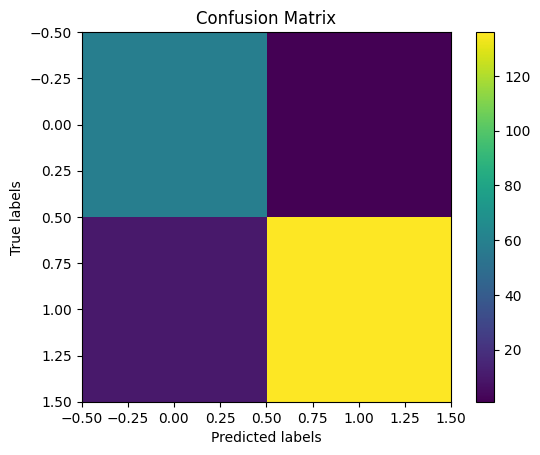

In [25]:
y_true_list = []
y_pred_list = []

for x, y in val_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [26]:
print(cm)

[[ 59   1]
 [ 10 136]]


## CONF MATRIX FOR TEST

In [ ]:
y_true_list = []
y_pred_list = []

for x, y in test_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

## OTHER MODELING TESTS

In [8]:
batch_size = 8
img_height = 224
img_width = 224
base_learning_rate = 0.001

data_dir= "Pollen_RawData/"

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,  # no need to shuffle validation set
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')



Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 206 files for validation.


## MOBILENETV2 (W/ Additional Layers)

In [56]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),  # flip horizontally and vertically
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # translate horizontally and vertically
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.GaussianNoise(1),
  tf.keras.layers.RandomContrast(0.75)
])

In [57]:
# Create the base model from the pre-trained model MobileNet V2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SIZE= (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=5)
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Add the custom classification part
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [58]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=100  # adjust this to control how often the learning rate decays
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1'),
                       tf.keras.metrics.AUC(name='auc')])


In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50


/home/txa4381/.local/lib/python3.10/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


104/104 [==============================] - 11s 76ms/step - loss: 2.0126 - accuracy: 0.3563 - precision: 0.3923 - recall: 0.2597 - f1: 0.3413 - auc: 0.6575 - val_loss: 0.7167 - val_accuracy: 0.8932 - val_precision: 0.9798 - val_recall: 0.4709 - val_f1: 0.3466 - val_auc: 0.9848
Epoch 2/50
104/104 [==============================] - 7s 66ms/step - loss: 0.9436 - accuracy: 0.5978 - precision: 0.6957 - recall: 0.5024 - f1: 0.5697 - auc: 0.8886 - val_loss: 0.4698 - val_accuracy: 0.8107 - val_precision: 0.8122 - val_recall: 0.7767 - val_f1: 0.3211 - val_auc: 0.9710
Epoch 3/50
104/104 [==============================] - 7s 65ms/step - loss: 0.5488 - accuracy: 0.7766 - precision: 0.8000 - recall: 0.7246 - f1: 0.7667 - auc: 0.9601 - val_loss: 0.1808 - val_accuracy: 0.9466 - val_precision: 0.9604 - val_recall: 0.9417 - val_f1: 0.3759 - val_auc: 0.9971
Epoch 4/50
104/104 [==============================] - 7s 67ms/step - loss: 0.3999 - accuracy: 0.8478 - precision: 0.8673 - recall: 0.8213 - f1: 0.840

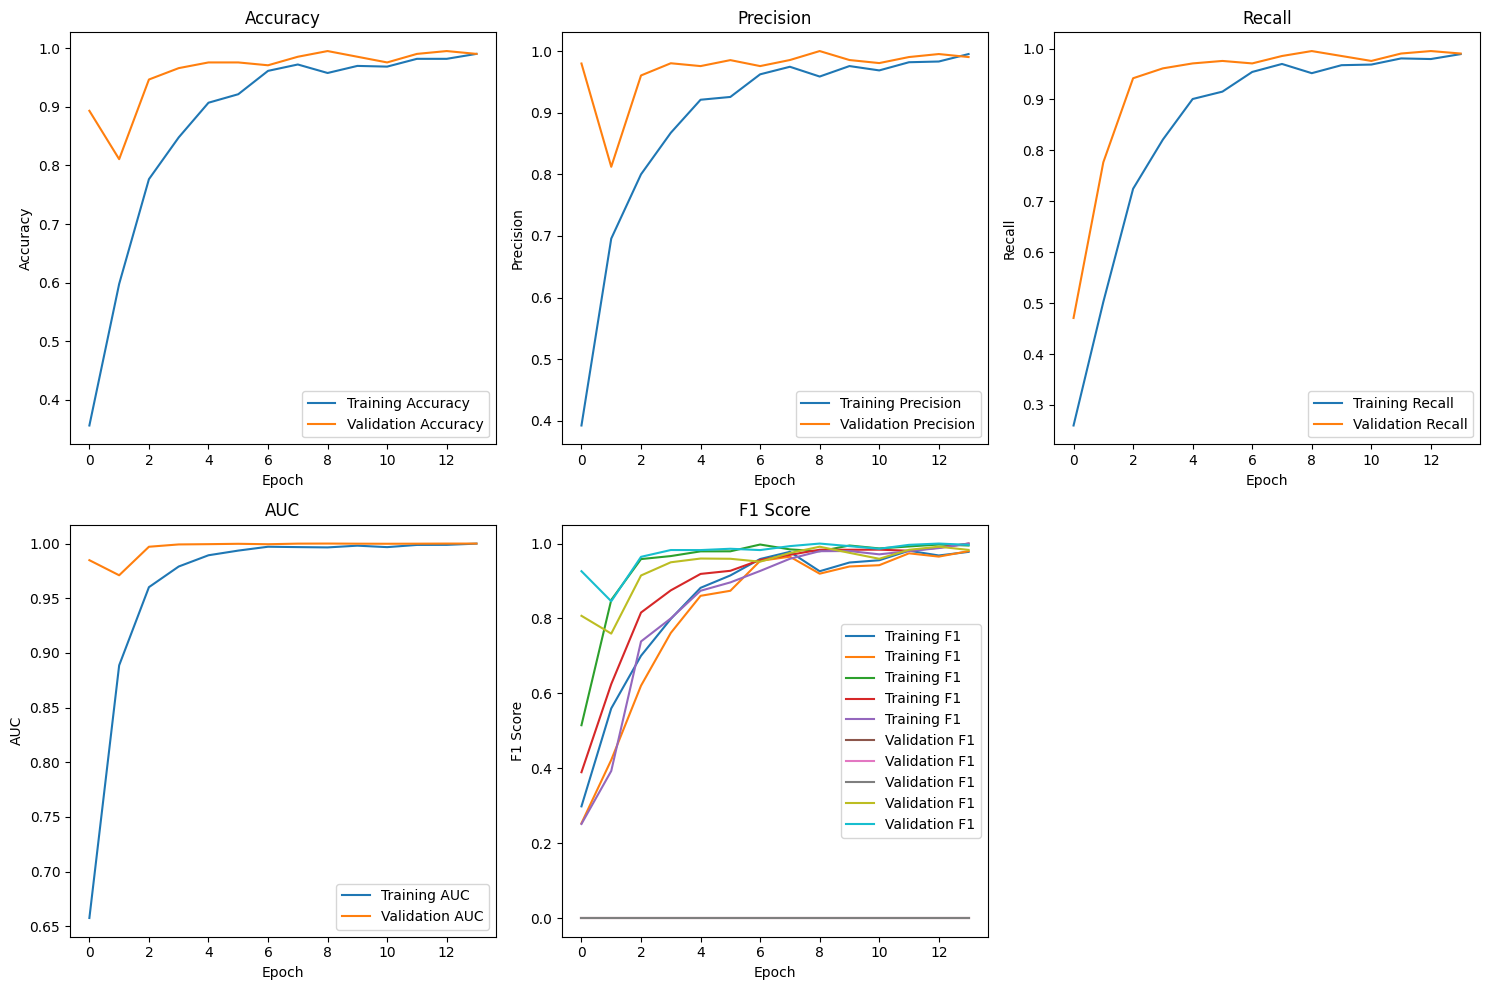

In [60]:


# Assuming you have the following metrics:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

# Create a figure and axis object
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Plot accuracy
ax[0, 0].plot(accuracy, label='Training Accuracy')
ax[0, 0].plot(val_accuracy, label='Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

# Plot precision
ax[0, 1].plot(precision, label='Training Precision')
ax[0, 1].plot(val_precision, label='Validation Precision')
ax[0, 1].set_title('Precision')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].legend()

# Plot recall
ax[0, 2].plot(recall, label='Training Recall')
ax[0, 2].plot(val_recall, label='Validation Recall')
ax[0, 2].set_title('Recall')
ax[0, 2].set_xlabel('Epoch')
ax[0, 2].set_ylabel('Recall')
ax[0, 2].legend()

# Plot AUC
ax[1, 0].plot(auc, label='Training AUC')
ax[1, 0].plot(val_auc, label='Validation AUC')
ax[1, 0].set_title('AUC')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].legend()

# Plot F1
ax[1, 1].plot(f1, label='Training F1')
ax[1, 1].plot(val_f1, label='Validation F1')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('F1 Score')
ax[1, 1].legend()

# Remove the last subplot (since we only have 5 metrics)
fig.delaxes(ax[1, 2])

# Show the plot
plt.tight_layout()
plt.show()

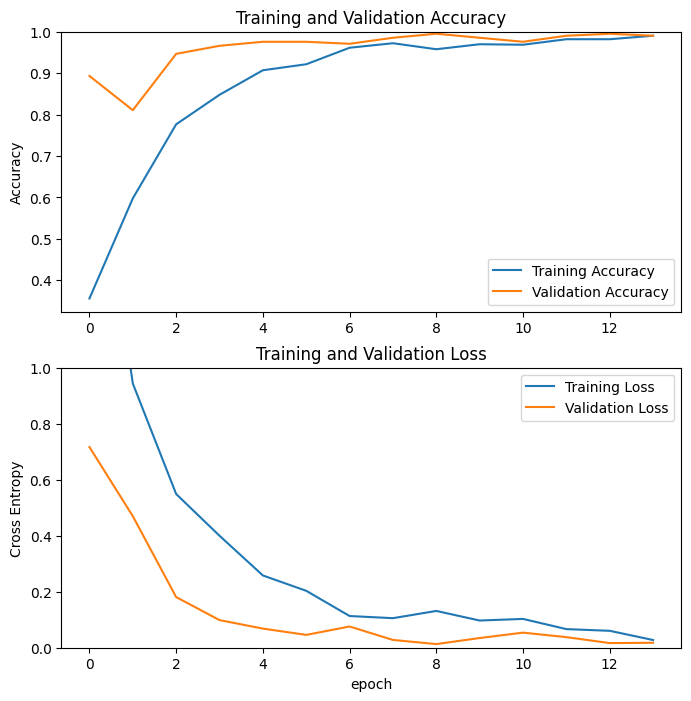

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 51ms/step


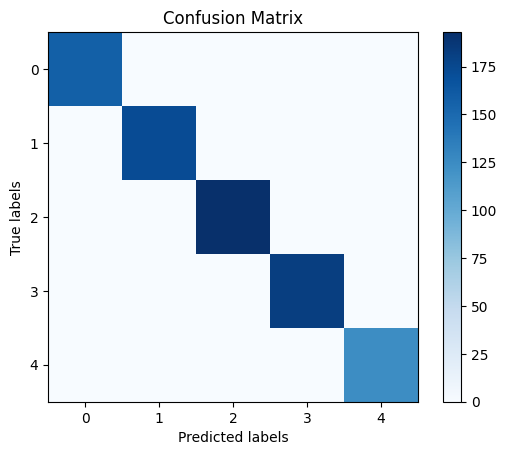

In [62]:
y_true_list = []
y_pred_list = []

for x, y in train_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [63]:
print(cm)

[[157   0   0   0   0]
 [  0 172   0   0   0]
 [  0   0 193   0   0]
 [  0   0   0 182   0]
 [  0   0   0   0 124]]


1/1 [==============================] - 0s 118ms/step


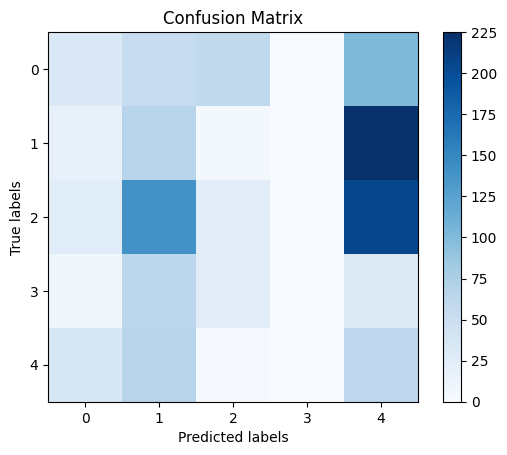

In [64]:
y_true_list = []
y_pred_list = []

for x, y in test_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [38]:
 print(cm)

[[ 10  52  21   0 162]
 [  5  62   1   0 244]
 [ 12 129   4   0 249]
 [  2  59   6   0  58]
 [  3  53   0   0 107]]


In [28]:
score = model.evaluate(test_ds, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 6.288459300994873
Test accuracy: 0.1476997584104538


Predictions:
 [0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1]
Labels:
 [[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


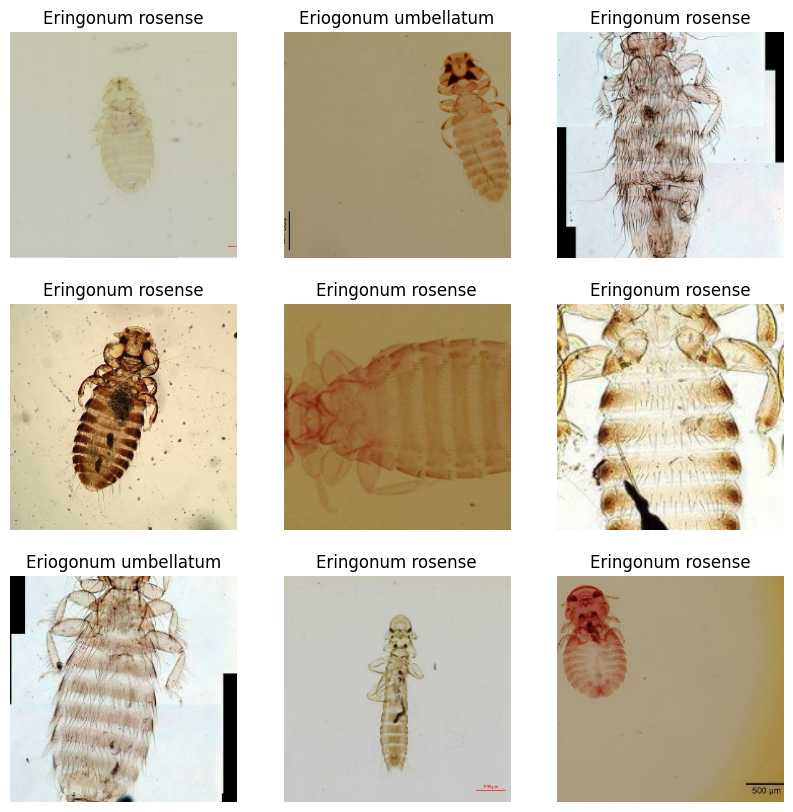

In [36]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Test was a success! lets try other models

## RESNET50

In [37]:
batch_size = 8
img_height = 224
img_width = 224
base_learning_rate = 0.001

data_dir= "Pollen_RawData/"

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,  # no need to shuffle validation set
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')



Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 206 files for validation.


In [39]:
# Create the base model from the pre-trained model MobileNet V2
preprocess_input = tf.keras.applications.resnet50.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SIZE= (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=5)

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Add the custom classification part
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=100  # adjust this to control how often the learning rate decays
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1'),
                       tf.keras.metrics.AUC(name='auc')])


In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
104/104 [==============================] - 18s 143ms/step - loss: 3.1035 - accuracy: 0.2705 - precision: 0.2649 - recall: 0.2041 - f1: 0.2647 - auc: 0.5765 - val_loss: 1.0475 - val_accuracy: 0.5097 - val_precision: 1.0000 - val_recall: 0.2039 - val_f1: 0.2048 - val_auc: 0.9123
Epoch 2/50
104/104 [==============================] - 14s 129ms/step - loss: 1.1427 - accuracy: 0.5507 - precision: 0.6270 - recall: 0.4263 - f1: 0.5246 - auc: 0.8432 - val_loss: 0.4937 - val_accuracy: 0.8932 - val_precision: 0.9679 - val_recall: 0.7330 - val_f1: 0.3539 - val_auc: 0.9892
Epoch 3/50
104/104 [==============================] - 14s 130ms/step - loss: 0.6163 - accuracy: 0.7258 - precision: 0.7723 - recall: 0.6679 - f1: 0.7130 - auc: 0.9500 - val_loss: 0.0319 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 0.4000 - val_auc: 1.0000
Epoch 4/50
104/104 [==============================] - 14s 130ms/step - loss: 0.4261 - accuracy: 0.8056 - precision: 0.8243 - recall: 

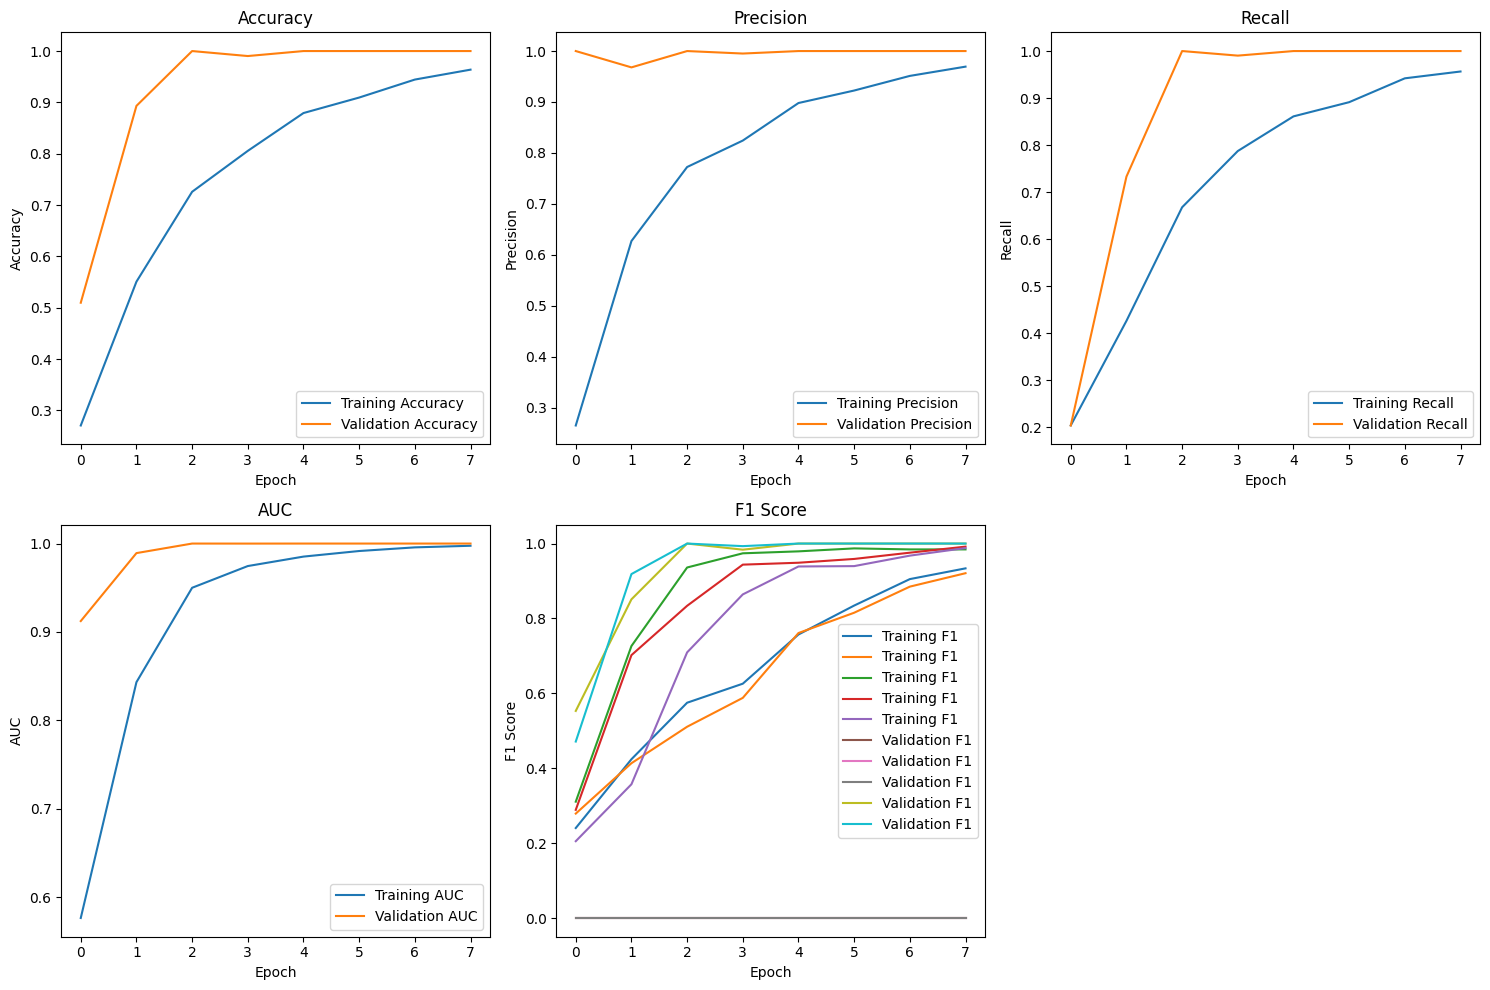

In [42]:


# Assuming you have the following metrics:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

# Create a figure and axis object
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Plot accuracy
ax[0, 0].plot(accuracy, label='Training Accuracy')
ax[0, 0].plot(val_accuracy, label='Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

# Plot precision
ax[0, 1].plot(precision, label='Training Precision')
ax[0, 1].plot(val_precision, label='Validation Precision')
ax[0, 1].set_title('Precision')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].legend()

# Plot recall
ax[0, 2].plot(recall, label='Training Recall')
ax[0, 2].plot(val_recall, label='Validation Recall')
ax[0, 2].set_title('Recall')
ax[0, 2].set_xlabel('Epoch')
ax[0, 2].set_ylabel('Recall')
ax[0, 2].legend()

# Plot AUC
ax[1, 0].plot(auc, label='Training AUC')
ax[1, 0].plot(val_auc, label='Validation AUC')
ax[1, 0].set_title('AUC')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].legend()

# Plot F1
ax[1, 1].plot(f1, label='Training F1')
ax[1, 1].plot(val_f1, label='Validation F1')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('F1 Score')
ax[1, 1].legend()

# Remove the last subplot (since we only have 5 metrics)
fig.delaxes(ax[1, 2])

# Show the plot
plt.tight_layout()
plt.show()

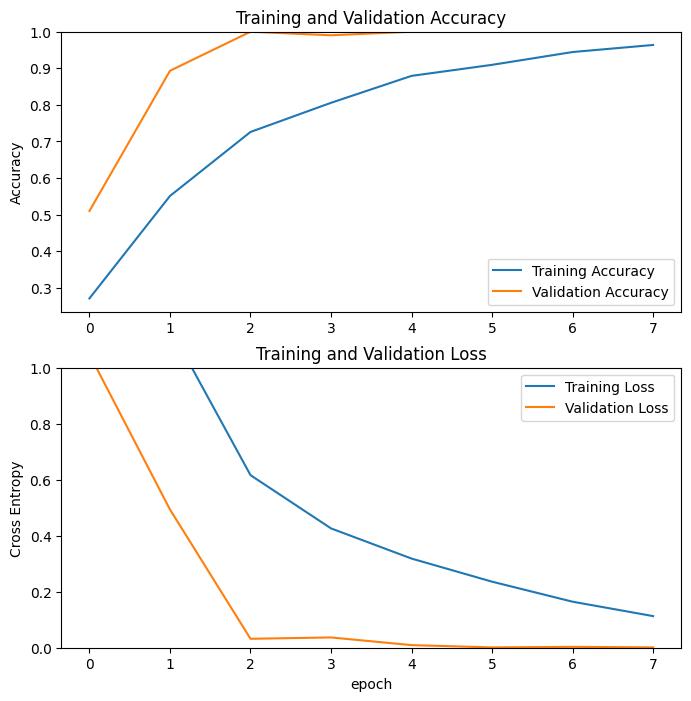

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 84ms/step


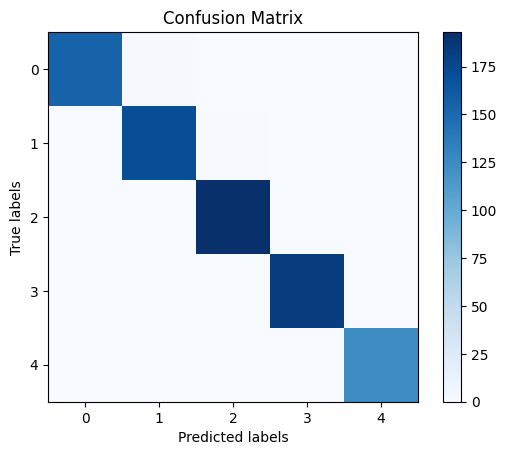

In [45]:
y_true_list = []
y_pred_list = []

for x, y in train_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [46]:
print(cm)

[[155   2   0   0   0]
 [  0 171   1   0   0]
 [  0   0 193   0   0]
 [  0   0   0 182   0]
 [  0   0   0   0 124]]


1/1 [==============================] - 0s 168ms/step


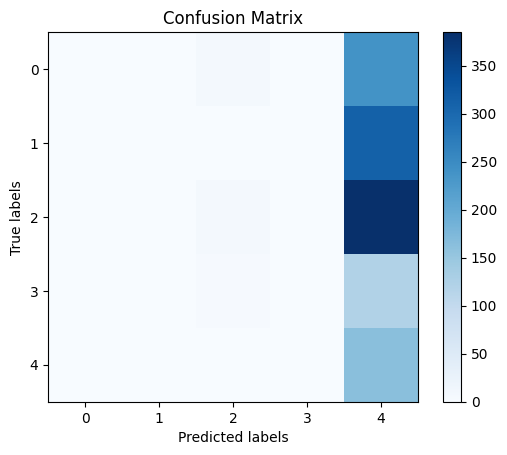

In [51]:
y_true_list = []
y_pred_list = []

for x, y in test_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [52]:
print(cm)

[[  0   0   7   0 238]
 [  0   0   0   0 312]
 [  0   0   9   0 385]
 [  0   0   4   0 121]
 [  0   0   0   0 163]]


In [53]:
score = model.evaluate(test_ds, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 10.308443069458008
Test accuracy: 0.13882163166999817


Predictions:
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1]
Labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


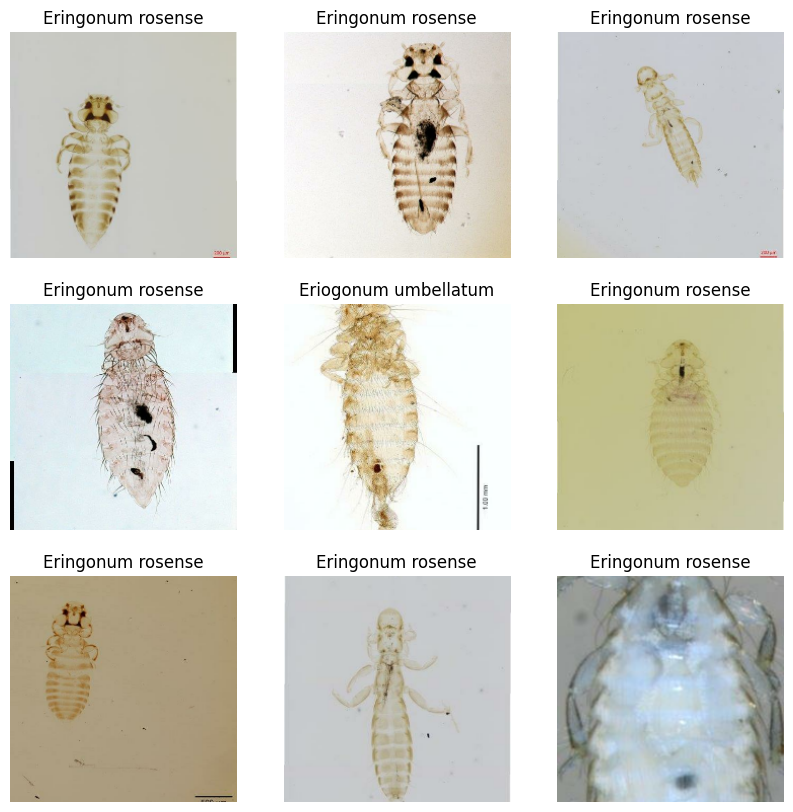

In [55]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## InceptionV3

In [9]:
batch_size = 8
img_height = 224
img_width = 224
base_learning_rate = 0.001

data_dir= "Pollen_RawData/"

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,  # no need to shuffle validation set
  crop_to_aspect_ratio=True,
  labels='inferred',
  label_mode='categorical',
  color_mode='rgb')



Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 206 files for validation.


In [11]:
# Create the base model from the pre-trained model MobileNet V2
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SIZE= (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=5)

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# Add the custom classification part
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=100  # adjust this to control how often the learning rate decays
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.F1Score(name='f1'),
                       tf.keras.metrics.AUC(name='auc')])


In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50


/home/txa4381/.local/lib/python3.10/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


104/104 [==============================] - 12s 68ms/step - loss: 2.7920 - accuracy: 0.2210 - precision: 0.2222 - recall: 0.1353 - f1: 0.2180 - auc: 0.5343 - val_loss: 1.6312 - val_accuracy: 0.2864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0915 - val_auc: 0.4721
Epoch 2/50
104/104 [==============================] - 5s 48ms/step - loss: 1.4198 - accuracy: 0.3937 - precision: 0.5570 - recall: 0.2065 - f1: 0.3640 - auc: 0.7212 - val_loss: 1.0770 - val_accuracy: 0.2961 - val_precision: 0.3897 - val_recall: 0.2573 - val_f1: 0.0933 - val_auc: 0.8534
Epoch 3/50
104/104 [==============================] - 5s 46ms/step - loss: 1.0316 - accuracy: 0.5314 - precision: 0.6752 - recall: 0.3841 - f1: 0.4888 - auc: 0.8585 - val_loss: 0.9640 - val_accuracy: 0.2913 - val_precision: 0.4085 - val_recall: 0.2816 - val_f1: 0.0920 - val_auc: 0.8752
Epoch 4/50
104/104 [==============================] - 5s 46ms/step - loss: 0.7834 - accuracy: 0.6582 - precision: 0.7333 - recall: 0.5314 - f

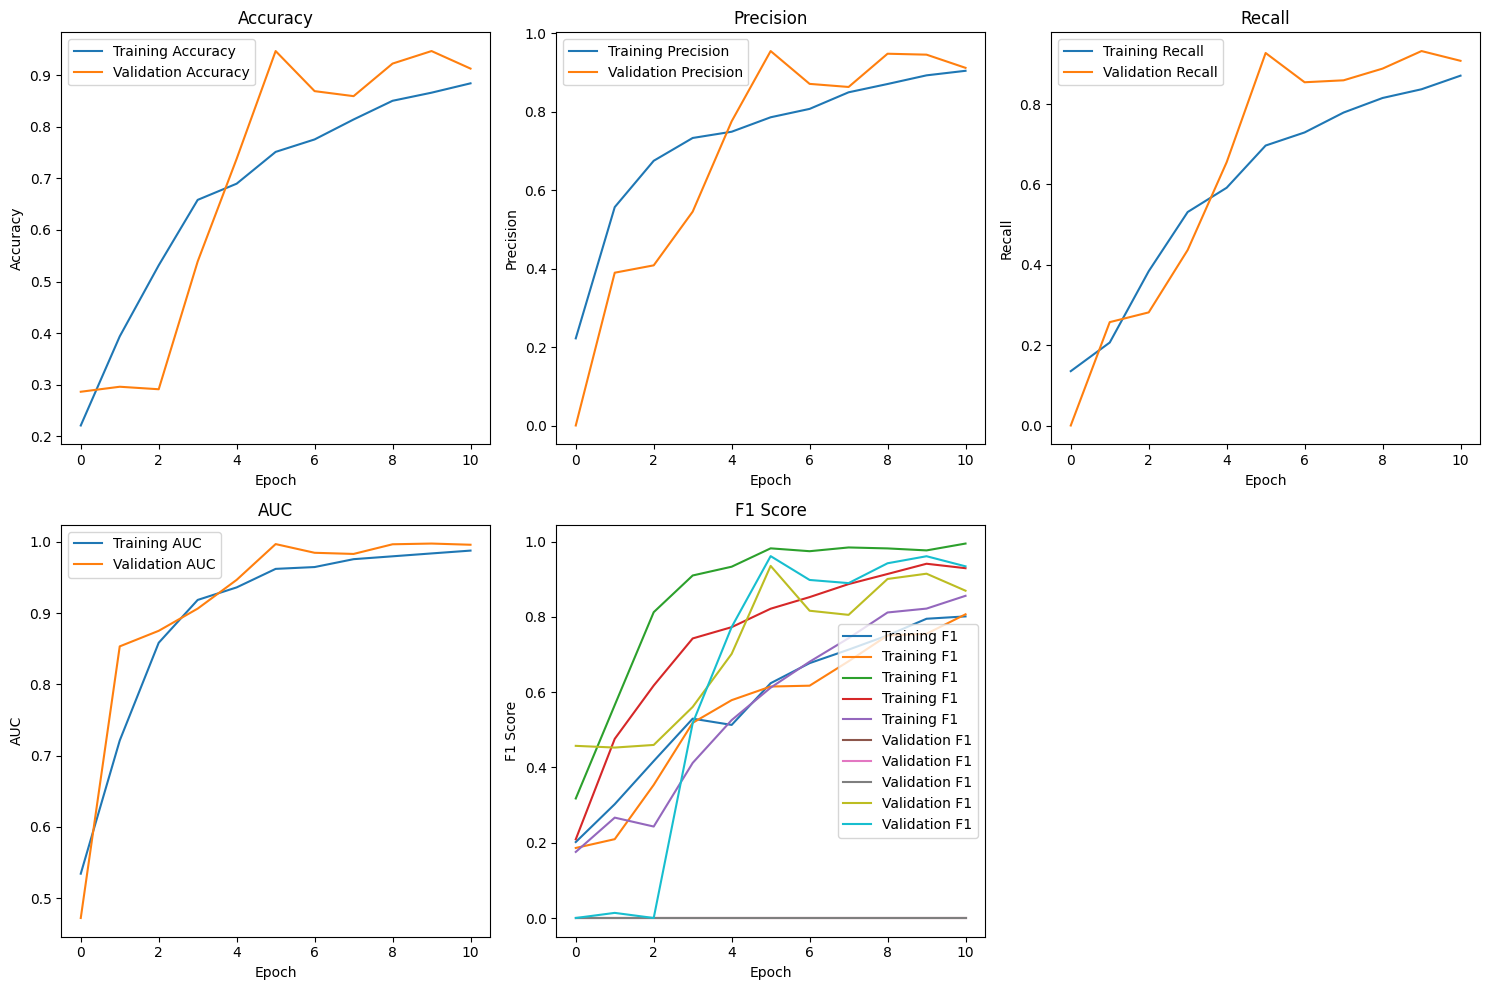

In [14]:


# Assuming you have the following metrics:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

f1 = history.history['f1']
val_f1 = history.history['val_f1']

# Create a figure and axis object
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Plot accuracy
ax[0, 0].plot(accuracy, label='Training Accuracy')
ax[0, 0].plot(val_accuracy, label='Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

# Plot precision
ax[0, 1].plot(precision, label='Training Precision')
ax[0, 1].plot(val_precision, label='Validation Precision')
ax[0, 1].set_title('Precision')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].legend()

# Plot recall
ax[0, 2].plot(recall, label='Training Recall')
ax[0, 2].plot(val_recall, label='Validation Recall')
ax[0, 2].set_title('Recall')
ax[0, 2].set_xlabel('Epoch')
ax[0, 2].set_ylabel('Recall')
ax[0, 2].legend()

# Plot AUC
ax[1, 0].plot(auc, label='Training AUC')
ax[1, 0].plot(val_auc, label='Validation AUC')
ax[1, 0].set_title('AUC')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('AUC')
ax[1, 0].legend()

# Plot F1
ax[1, 1].plot(f1, label='Training F1')
ax[1, 1].plot(val_f1, label='Validation F1')
ax[1, 1].set_title('F1 Score')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('F1 Score')
ax[1, 1].legend()

# Remove the last subplot (since we only have 5 metrics)
fig.delaxes(ax[1, 2])

# Show the plot
plt.tight_layout()
plt.show()

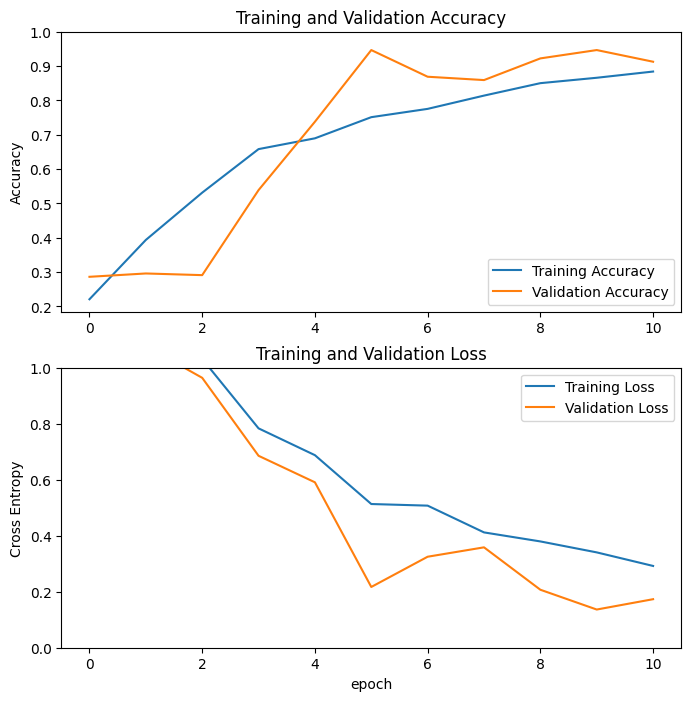

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

39/39 [==============================] - 3s 71ms/step - loss: 2.7125 - accuracy: 0.1517 - precision: 0.1361 - recall: 0.0888 - f1: 0.1344 - auc: 0.4640


ValueError: too many values to unpack (expected 2)

1/1 [==============================] - 0s 54ms/step


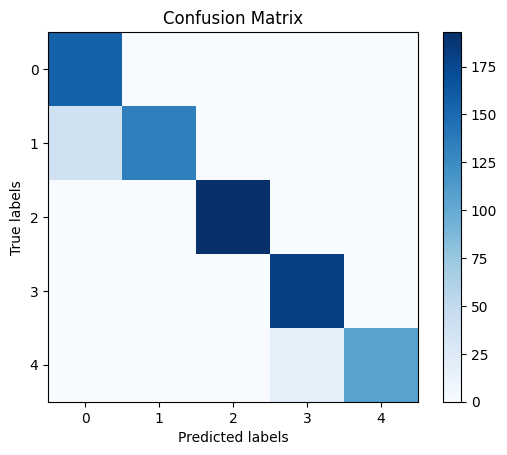

In [18]:
y_true_list = []
y_pred_list = []

for x, y in train_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [19]:
print(cm)

[[156   1   0   0   0]
 [ 38 134   0   0   0]
 [  0   0 193   0   0]
 [  0   0   0 181   1]
 [  0   0   0  17 107]]


1/1 [==============================] - 0s 95ms/step


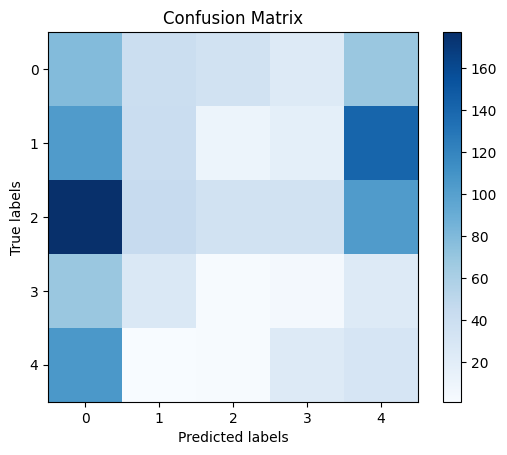

In [20]:
y_true_list = []
y_pred_list = []

for x, y in test_ds:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

y_true_class = tf.argmax(tf.concat(y_true_list, axis=0), axis=1)
y_pred_class = tf.argmax(tf.concat(y_pred_list, axis=0), axis=1)

cm = sklearn.metrics.confusion_matrix(y_true_class, y_pred_class)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

In [21]:
print(cm)

[[ 78  40  35  23  69]
 [103  41  10  17 141]
 [177  44  35  35 103]
 [ 69  26   2   4  24]
 [106   1   2  24  30]]


Predictions:
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


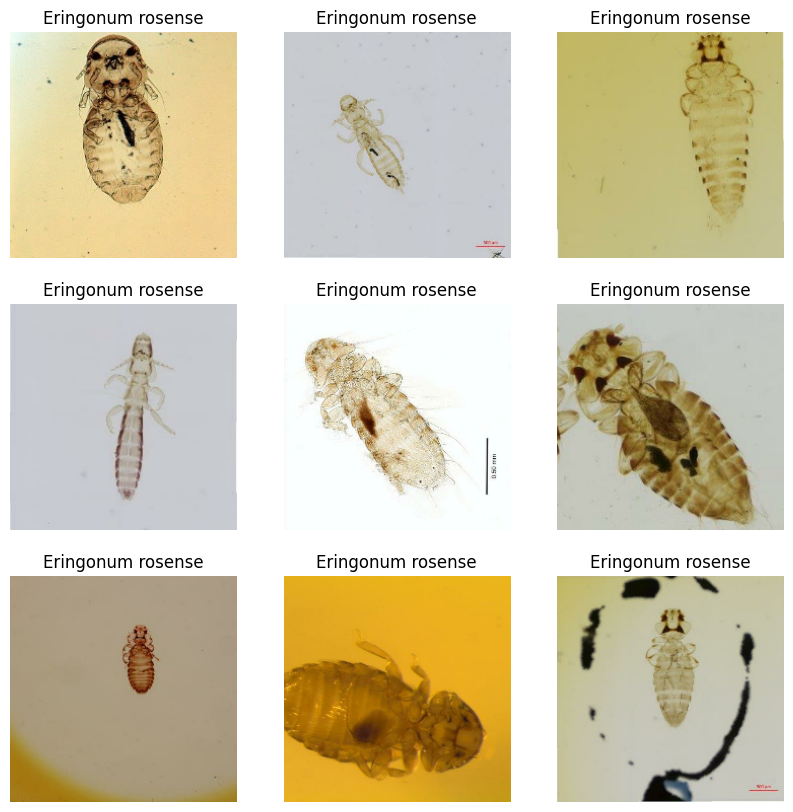

In [26]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")